# Building micrograd

In this notebook we walkthrough the code used to build [micrograd](https://github.com/karpathy/micrograd): a basic automatic differentiation library to train small neural networks in Python. 

This is based on Andrej's YouTube video: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)



## The Value class

This is the fundamental unit of micrograd that encapsulates a scalar variable and enables us to get it's gradient with respect to other values in the same equation.

For example in:
``` python
a = 10
b = 5
c = a * b
```

```Value``` will help us find that respective to the c the gradients of a and b are:

``` python
d_of_a = 5
d_of_b = 10
```

This is then done using the chain rule, as defined by:
```
dL/dd = dL/dx * dx/dd
```

where ```dx``` is an intermediary variable

In practice and at a high level, this mean for multiplication the gradient will be the product of next node in the chain times the node it's being multiplied by and for addition, the gradient is simply passed down the chain with no modification.

In [1]:
import math
from typing import Self

class Value:
    def __init__(self, data: float, _children: tuple[Self, Self]=(), _operation: str = '', label: str='', grad: float = 0) -> None:
        self.data: float = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = grad
        self._backward = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label}, {self.data})'
    
    def __add__(self, other: Self | float):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other: Self | float):
        return self * other
    
    def exp(self):
        starting_data = self.data
        out = Value(math.exp(starting_data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other: Self | float):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4
L

print(9 + a - 2)

Value(, 9.0)


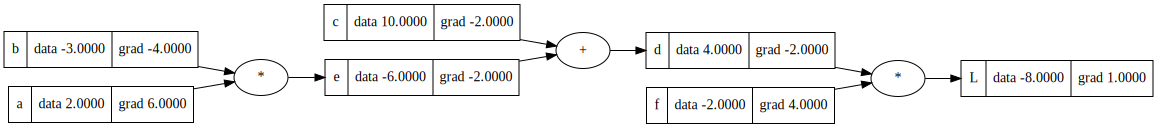

In [13]:
from graphviz import Digraph

def trace(root: Value):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operation, label = n._operation)
      # and connect this node to it
      dot.edge(uid + n._operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

draw_dot(L)

In [3]:
def man_grad():
    h = 0.001
  
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'    
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    
    
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
man_grad()
 
    

-3.9999999999995595


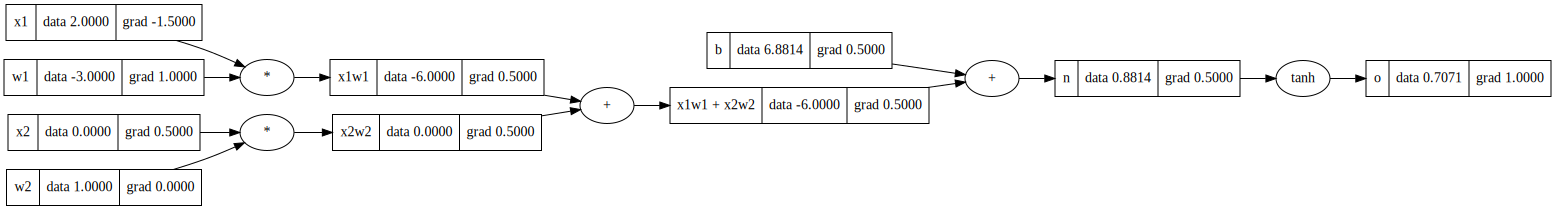

In [4]:
# Inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Biases
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'; o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)


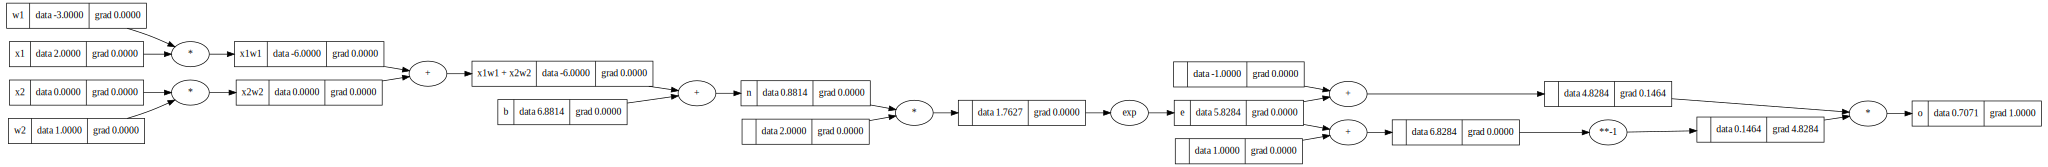

In [5]:
# Inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Biases
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'; o.grad = 1
# o.backward()
o._backward()
draw_dot(o)


## The neural network

Here we define the core components that help transform a scalar value into a neural network.

### Neuron

This is a single node in a layer that is:
a. trainable
b. is fully connected to the previous layer -> each feature for the layer and each neuron in the previous layer for a hidden layer
c. outputs a scalar (the activation)
d. has n + b trainable parameters where n = the number of inputs from the previous layer and b is the bias
e. it's scalar output is delinearised and  constricted using an activation function, for example, RELU or tanh

### Layer

A layer is a list of neurons, not connected to each other but fully connected to all neurons in the layers surrounding it.

### MultiLayerPerceptron

The MLP brings together n number of layers to estimate a non-linear function f where f(x)=y

It takes two input parameters:
a. nin - the number of features
b. nouts - a list containing the number of neurons in each hidden layer.


In [6]:
import random


class Neuron:
    # Number of inputs is the number of features for the first layer and number size of the previous layer if not
    def __init__(self, number_of_inputs: int) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x: list[Value] | list[float]) -> Value:
        activation = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = activation.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    # Number of inputs is the number of features for the first layer and number size of the previous layer if not
    # Number of outputs is the number of neurons in this layer, that then get integrated with the following layer
    def __init__(self, number_of_inputs: int, number_of_outputs: int) -> None:
        self.neurons = [Neuron(number_of_inputs=number_of_inputs) for _ in range(number_of_outputs)]
        
    def __call__(self, x: list[Value] | list[float]) -> Self:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MultiLayerPerceptron:
    def __init__(self, nin: int, nouts: list[int]) -> None:
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[n], sizes[n+1]) for n in range(len(nouts))]
        
    def __call__(self, x: list[float]):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
        
    

x = [2,3, 4]
n = MultiLayerPerceptron(3, [4,4,1])
predictions =n(x)
n.parameters()
        

[Value(, 0.760589417553418),
 Value(, -0.42982923195183265),
 Value(, 0.221826971988502),
 Value(, -0.9075688507568227),
 Value(, -0.5508191860109133),
 Value(, 0.580760827936794),
 Value(, -0.8835792119013188),
 Value(, -0.599360353523972),
 Value(, -0.6774300237434512),
 Value(, -0.3663756766938717),
 Value(, 0.7924719318474445),
 Value(, 0.37414857389768663),
 Value(, -0.32870544372293486),
 Value(, 0.12680781589670076),
 Value(, 0.39088822096600095),
 Value(, 0.46513889079598947),
 Value(, -0.6020109378104415),
 Value(, -0.5664262924454817),
 Value(, 0.9707951515167976),
 Value(, 0.4570897143304906),
 Value(, -0.751303048156388),
 Value(, -0.6410053308320502),
 Value(, -0.40908268298743256),
 Value(, -0.033930729626159506),
 Value(, -0.13125480783790744),
 Value(, -0.41624836112522257),
 Value(, -0.34890011535751464),
 Value(, 0.7335503749777672),
 Value(, -0.4290714834821545),
 Value(, 0.36976249364549973),
 Value(, 0.9167097284047911),
 Value(, 0.9200968656529027),
 Value(, 0.164

In [7]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  
  print(k, loss.data)
  # loss = sum((y_actual - y_pred) for y_actual, y_pred in zip(ys, predictions))

0 3.389413137328798
1 3.1241779899570563
2 2.8243373495176183
3 2.4719109829485624
4 2.078776480993888
5 1.6891289866797428
6 1.3533888049983054
7 1.0929748622489126
8 0.8998701529721025
9 0.7567846254580707
10 0.6487677473963053
11 0.5652890931249394
12 0.4992992622582746
13 0.446072389033145
14 0.40238003488793994
15 0.3659645141864181
16 0.3352097862036434
17 0.3089337767224947
18 0.28625470490075433
19 0.26650308975099596


In [8]:
ypred

[Value(, 0.7921076928185743),
 Value(, -0.8635451423135562),
 Value(, -0.6204970978946727),
 Value(, 0.7537450559416392)]

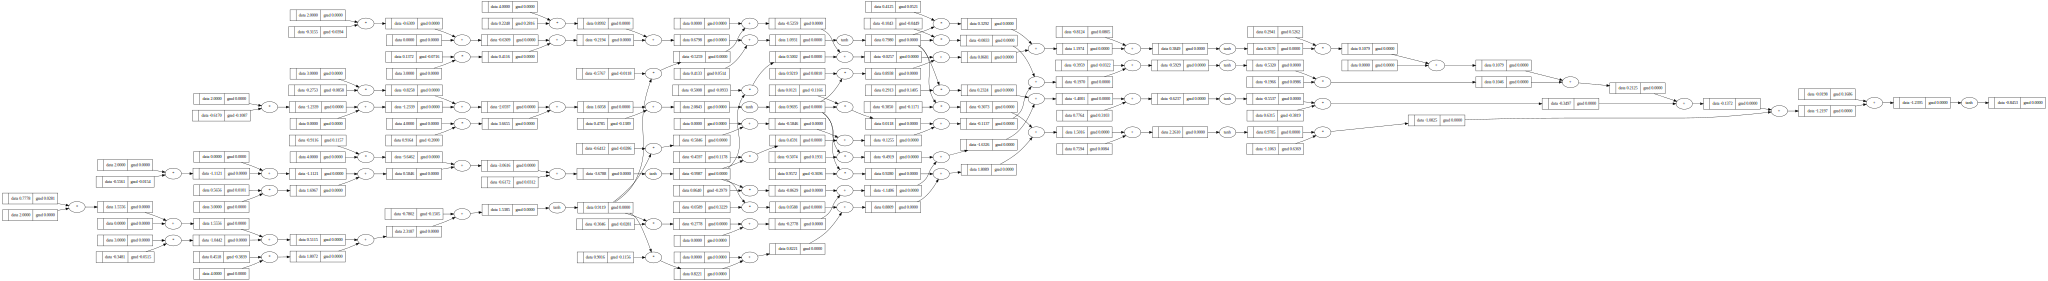

In [9]:
draw_dot(n(x))

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [10]:
import torch

x1 = torch.Tensor([2]).double(); x1.requires_grad = True
x2 = torch.Tensor([0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3]).double(); w1.requires_grad = True
w2 = torch.Tensor([1]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0
